### Quantum Convolution

The idea of CNN is to apply a local convolution instead of processing the entire input data with a global function. If the input is an image then small regions are sequentially processed using the same kernel. One can extend this idea in the context of quantum variational circuits. An approach for the same is given below which is similar to the apporach in https://arxiv.org/abs/1904.04767.

1. A small region of input image, in our example a 2*2 square image, is embedded into a quantum circuit. In this demo, it is achieved with paramaterized rotations applied to the qubits initialized in ground state.
2. A quantum computation, associated to a unitary U, is performed on the system. The unitary could be generated by a variational quantum circuit or, more simply, by a random circuit as proposed in the above paper.
3. The quantum system is finally measured, obtaining a list of classical expectation value which is used for further processing.
4. Similar to the classical convolutional layer, each expectation value is mapped to a different channel of a single output pixel.
5. Iterating the same process over different regions, one can scan the complete input image and produce an output object which will be structured as a multi-channel image.
6. The quantum convolution can be followed by further quantum layers or by classical layers.

The above scheme is also represented by the figure below.

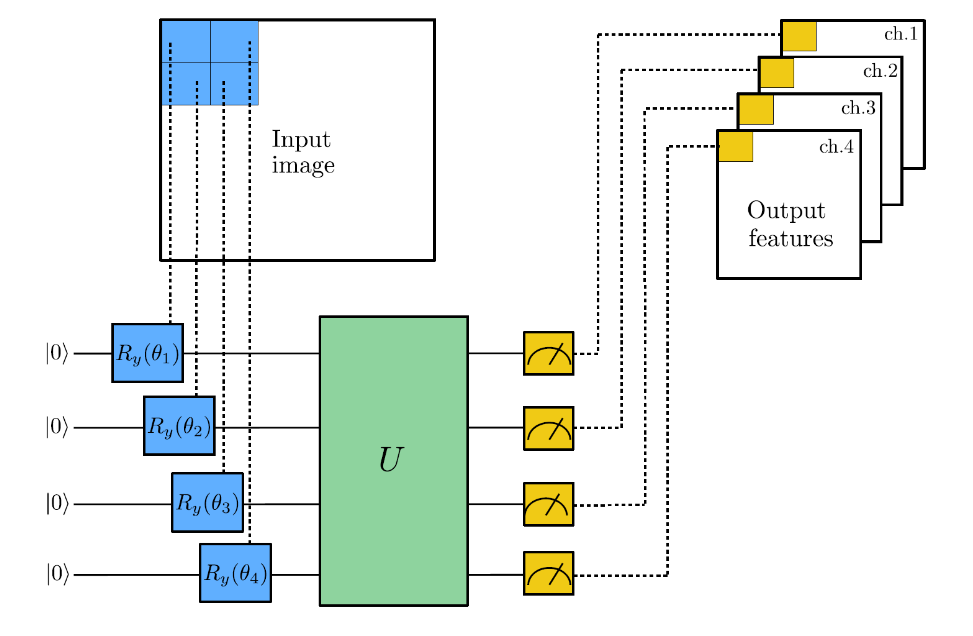

The main difference between the classical and quantum approach is that a quantum circuit can generate highly complext kernels, whose computation would be, at least in principle, classically very diffcult to compute.

In [1]:
# Importing Libraries
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

### Setting up the main hyper-parameters of the model

In [2]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

We will import the MNIST dataset from Keras. To reduce the time for evaluation we are using small number of training and test images. Better results are achievable using the full dataset.

In [3]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) =  mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

### Quantum circuit as convolutional layer

We will follow the same procedure as stated at the beginning. 

We initialize a PennyLane default.qubit device with 4 qubits. The associated qnode represents the quantum circuit consisting of:

1. an embedding layer of local Ry rotations (with angles scaled by a factor of π).
2. a random circuit of n_layers.
3. a final measurement in the computational basis, estimating 4 expectation values.

In [4]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

The next function defines the convolution scheme:

1. the image is divided into squares of 2*2 pixels.
2. each square is processed by the quantum circuit.
3. the 4 expectation values are mapped into 4 different channels of single output pixel.

In [5]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

### Quantum pre-processing of the dataset

Since we are not going to train the quantum convolution layer, it is more efficient to apply it as a “pre-processing” layer to all the images of our dataset. Later an entirely classical model will be directly trained and tested on the pre-processed dataset, avoiding unnecessary repetitions of quantum computations.

The pre-processed images will be saved in the folder SAVE_PATH. Once saved, they can be directly loaded by setting PREPROCESS = False, otherwise the quantum convolution is evaluated at each run of the code.

In [6]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


Visualizing the effect of quantum convolutional layer on a batch of samples.

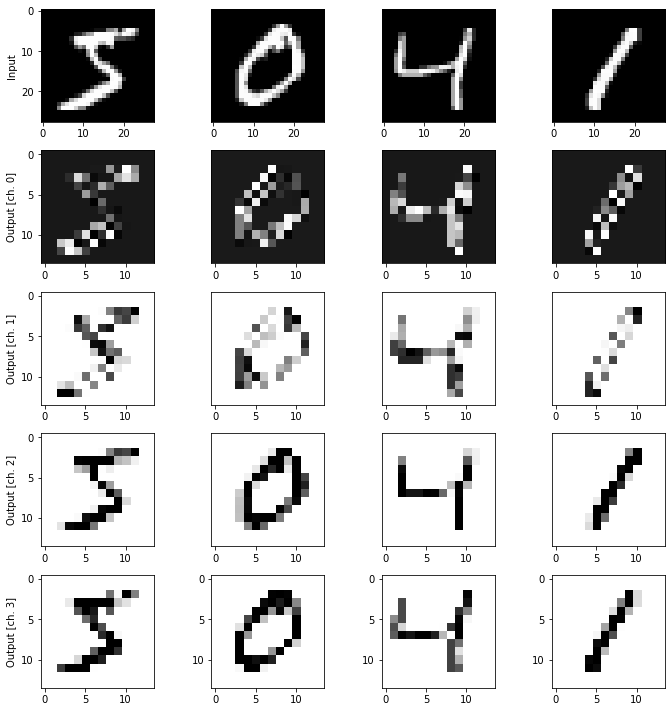

In [7]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

Below each input image, the 4 output channels generated by the quantum convolution are visualized in gray scale.

We can clearly see the images have been downscaled and some local distortion has been added to the input by the quantum kernel. And clearly the global shape of the image is perserved as expected from a convolutional layer.

### Hybrid quantum-classical model

After the application of the quantum we feed the resulting features into a classical neural network that will be trained to classify the 10 different digits of the MNIST dataset.

We use a very simple model: just a fully connected layer with 10 output nodes with a final softmax activation function.

The model is compiled with a stochastic-gradient-descent optimizer, and a cross-entropy loss function.

In [8]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

### Training

We first initialize an instance of the model, then we train and validate it with the dataset that has been already pre-processed by a quantum convolution.

In [9]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.9351 - accuracy: 0.1000 - val_loss: 2.3946 - val_accuracy: 0.1000 - 1s/epoch - 93ms/step
Epoch 2/30
13/13 - 0s - loss: 2.1241 - accuracy: 0.2800 - val_loss: 2.1525 - val_accuracy: 0.2000 - 106ms/epoch - 8ms/step
Epoch 3/30
13/13 - 0s - loss: 1.7218 - accuracy: 0.5600 - val_loss: 2.0267 - val_accuracy: 0.3333 - 118ms/epoch - 9ms/step
Epoch 4/30
13/13 - 0s - loss: 1.3012 - accuracy: 0.6400 - val_loss: 1.7713 - val_accuracy: 0.4000 - 108ms/epoch - 8ms/step
Epoch 5/30
13/13 - 0s - loss: 1.0990 - accuracy: 0.8000 - val_loss: 1.6480 - val_accuracy: 0.4333 - 90ms/epoch - 7ms/step
Epoch 6/30
13/13 - 0s - loss: 0.9181 - accuracy: 0.8000 - val_loss: 1.6461 - val_accuracy: 0.3667 - 95ms/epoch - 7ms/step
Epoch 7/30
13/13 - 0s - loss: 0.7147 - accuracy: 0.9400 - val_loss: 1.5006 - val_accuracy: 0.4667 - 91ms/epoch - 7ms/step
Epoch 8/30
13/13 - 0s - loss: 0.5779 - accuracy: 0.9600 - val_loss: 1.4361 - val_accuracy: 0.5333 - 93ms/epoch - 7ms/step
Epoch 9/30
13/13 - 0s 

In order to compare the results achievable with and without the quantum convolution layer, we initialize also a “classical” instance of the model that will be directly trained and validated with the raw MNIST images (i.e., without quantum pre-processing).

In [10]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.3920 - accuracy: 0.1000 - val_loss: 2.3593 - val_accuracy: 0.0333 - 863ms/epoch - 66ms/step
Epoch 2/30
13/13 - 0s - loss: 2.0247 - accuracy: 0.2600 - val_loss: 2.1961 - val_accuracy: 0.1000 - 115ms/epoch - 9ms/step
Epoch 3/30
13/13 - 0s - loss: 1.7295 - accuracy: 0.5200 - val_loss: 2.0452 - val_accuracy: 0.2000 - 108ms/epoch - 8ms/step
Epoch 4/30
13/13 - 0s - loss: 1.4920 - accuracy: 0.7400 - val_loss: 1.8979 - val_accuracy: 0.3000 - 107ms/epoch - 8ms/step
Epoch 5/30
13/13 - 0s - loss: 1.2813 - accuracy: 0.8800 - val_loss: 1.7643 - val_accuracy: 0.5000 - 99ms/epoch - 8ms/step
Epoch 6/30
13/13 - 0s - loss: 1.1111 - accuracy: 0.9000 - val_loss: 1.6653 - val_accuracy: 0.5000 - 99ms/epoch - 8ms/step
Epoch 7/30
13/13 - 0s - loss: 0.9656 - accuracy: 0.9200 - val_loss: 1.5896 - val_accuracy: 0.5667 - 104ms/epoch - 8ms/step
Epoch 8/30
13/13 - 0s - loss: 0.8459 - accuracy: 0.9400 - val_loss: 1.5169 - val_accuracy: 0.6333 - 99ms/epoch - 8ms/step
Epoch 9/30
13/13 -

### Results

We can finally plot the test accuracy and the test loss with respect to the number of training epochs.

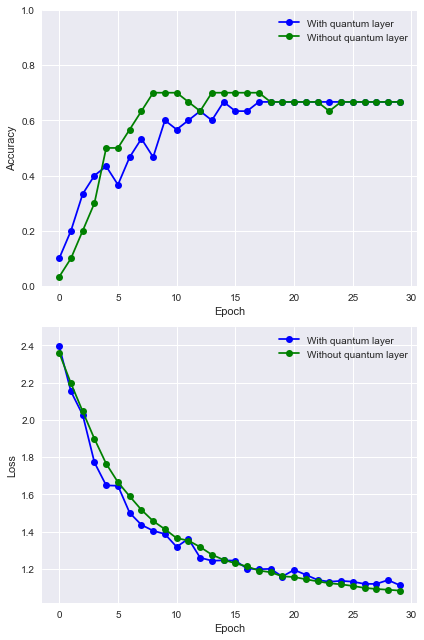

In [11]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

### References 
1. Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan Cook. “Quanvolutional Neural Networks: Powering Image Recognition with Quantum Circuits.” arXiv:1904.04767, 2019.
2. Ville Bergholm, Josh Izaac, Maria Schuld, Christian Gogolin, Carsten Blank, Keri McKiernan and Nathan Killoran. PennyLane. arXiv, 2018. arXiv:1811.04968